In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.pinopi as pnp
import analysis.plotting as plotting

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
general_vals_dict['TWPA_freq'] = 8.6
general_vals_dict['TWPA_pwr'] = 1.4
print(f"{q1}\n{q2}")

Qubit(ef_amp=0.5, ro_dur=4000, ef_time=76, IQ_angle=205, RO_LO_pwr=16, ROIF=0.10280000000000022, ge_time=35.487201481, qubit_id=q1, ro_freq=6.7275, RO_LO=6.6247, ge_ssm=-0.114, qubit_thr=[-10000, -600], RO_IF=None, ge_amp=1, ro_amp=1, ef_ssm=-0.257)
Qubit(ef_amp=1, ro_dur=4000, ef_time=None, IQ_angle=85, RO_LO_pwr=16, ROIF=0.030899999999999928, ge_time=23.610582067254867, qubit_id=q2, ro_freq=6.6556, RO_LO=6.6247, ge_ssm=-0.154, qubit_thr=[-10000, 1900], RO_IF=None, ge_amp=1, ro_amp=1, ef_ssm=-0.224)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
num_steps = 3
reps = 100000
swap_freq= -.0192
swap_time=0.5*7/abs(swap_freq)#193.5253031907684

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 100000
Buffers per acquistion: 98
DAQ samples per pattern: 8192
0, No error
Capturing 98 buffers. Press <enter> to abort
Capture completed in 40.177476 sec
Captured 98 buffers (2.439178 buffers per sec)
Captured 301056 records (7493.153595 records per sec)
Transferred 4932501504 bytes (122767828.507058 bytes per sec)


<Figure size 800x800 with 0 Axes>

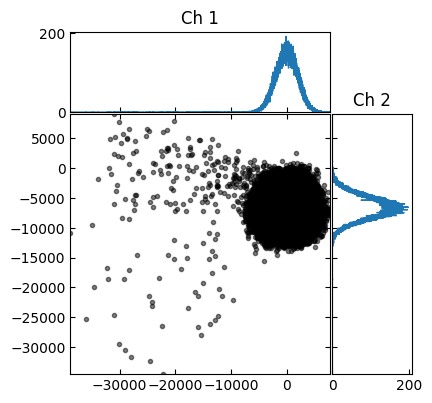

<Figure size 800x800 with 0 Axes>

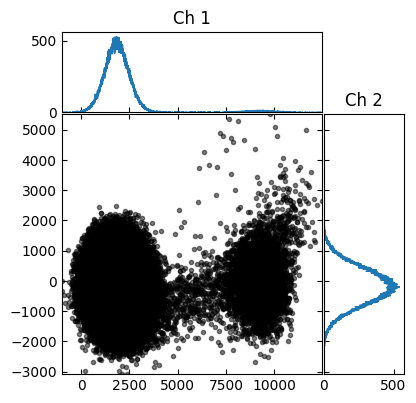

saved G
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 100000
Buffers per acquistion: 98
DAQ samples per pattern: 8192
0, No error
Capturing 98 buffers. Press <enter> to abort


In [ ]:
for i in range(3):
    if 0 == i:
        label = 'G'
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 0,copige = 0,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time)
    elif 1 == i:
        label = 'E'
        # E prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 0, coswap = 0,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time)
    elif 2 == i:
        label = 'F'
        # F prep
        pnp.pi_nopi_swap(q1, q2, general_vals_dict, copief = 1, coswap = 0,copige = 1,num_steps = 3,swap_freq =  swap_freq, swap_time = swap_time)

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    values = daq.run_daq_het_2q(q1, q2,
                    num_patterns=num_steps, num_records_per_pattern=reps,
                        verbose=True)

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0][0:reps*num_steps]
    Q1_raw = values.rec_readout_1[1][0:reps*num_steps]
    I2_raw = values.rec_readout_2[0][0:reps*num_steps]
    Q2_raw = values.rec_readout_2[1][0:reps*num_steps]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    if 0 == i:
        g_IQ = IQ_df
    elif 1 == i:
        e_IQ = IQ_df
    else:
        f_IQ = IQ_df
    IQ_df.to_csv(f'IQraw{label}.csv')
    print(f"saved {label}")

In [ ]:
g_IQ['label'] = [0 for _ in range(len(g_IQ))]
e_IQ['label'] = [1 for _ in range(len(e_IQ))]
f_IQ['label'] = [2 for _ in range(len(f_IQ))]

three_state = pd.concat([g_IQ, e_IQ, f_IQ ], axis = 0)
try:
    three_state = three_state.drop(columns="Unnamed: 0")
except:
    pass
three_state = three_state.sample(frac=1).reset_index(drop=True)
three_state.head()

,I1,Q1,I2,Q2,label
0,-27277.370337,-9165.144574,1820.911746,-252.509296,1
1,-25687.509995,-7571.559483,1846.728237,228.468456,1
2,-31774.302876,-16895.120964,1594.611661,64.090068,2
3,-31052.139887,-4237.913496,2230.872323,17.120605,1
4,-34239.215379,-1283.134769,1925.380321,-802.586221,2


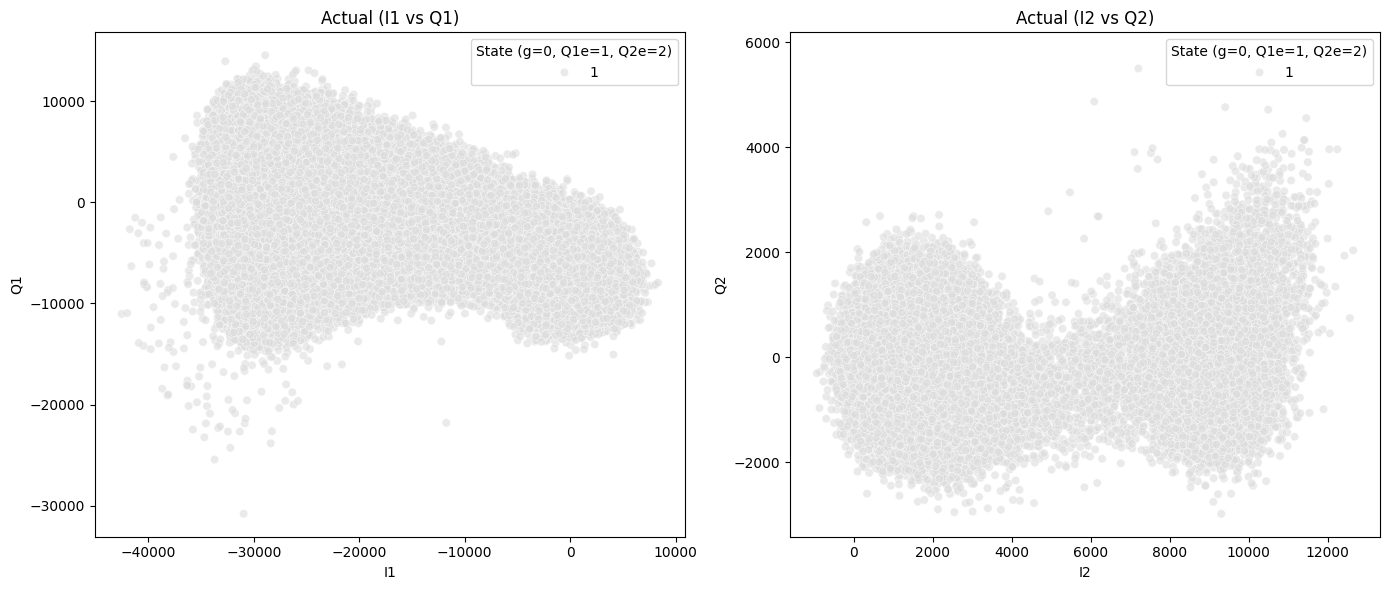

In [13]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sliced_data = three_state[three_state['label'] == 1]##[three_state['label'] == 2]
# First subplot: I1 vs Q1
sns.scatterplot(
    data=sliced_data,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=sliced_data,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, Q1e=1, Q2e=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()